# The Problem

The problem we are trying to solve is to build a model that can accurately re-style photos into the style of a Monet painting.

For this, we will build a Generative Adversarial Network (GAN). A GAN essentially pits two neural networks, a generator and a discriminator, against each other.  

The generator, given our photos, will try to re-style the images into a Monet style, and the discriminator (being given both generated images and Monet paintings) will try and accurately classify real vs fake Monet paintings.

In the end, we hope to end up with a model capable of solving the problem.

Generative networks, in general, are capable of generating images by starting with noise and progressively refining it into realistic images by learning patterns from training data (in this case, we are not building images from scratch as we are re-styling existing photos, but the principle still holds). These models do this by learning the underlying distribution of a dataset.

# Imports

Import our required libraries.  Included is some code for initializing the Kaggle TPU if needed.

In [1]:
import os
import PIL
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Activation, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input, Dropout, Concatenate, ZeroPadding2D
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print(e)
    print('failed to use TPU')
    strategy = tf.distribute.get_strategy()



TPUs not found in the cluster. Failed in initialization: No OpKernel was registered to support Op 'ConfigureDistributedTPU' used by {{node ConfigureDistributedTPU}} with these attrs: [is_global_init=false, tpu_cancellation_closes_chips=2, compilation_failure_closes_chips=false, embedding_config="", enable_whole_mesh_compilations=false, tpu_embedding_config=""]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[ConfigureDistributedTPU]] [Op:__inference__tpu_init_fn_4]
failed to use TPU


# Define Image Sampling Function

We will use this function to display random images from each dataset as part of our EDA/analysis.

In [2]:
import random

def display_random_images(image_paths, title, n):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(random.sample(image_paths, n)):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  
        plt.subplot(1, n, i + 1)
        plt.imshow(image.numpy())
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()


# EDA: Monet Images

We are given two datasets for this challenge - a set of images of Monet paintings, which is relatively small, and a larger set of real photos.

As we can see below, we have about 300 Monet images, with an image dimension of 256x256x3.  This dimension represents an image of 256 pixels x 256 pixels, where each pixel is represented by 3 RGB numerical color values.

We inspect a few of the images below.  For those not familiar with Monet, it's clear from this initial inspection that he has a distinct painting style that is somewhat softened and diffused.

Total number of Monet images: 300
Image Dimensions: (256, 256, 3)


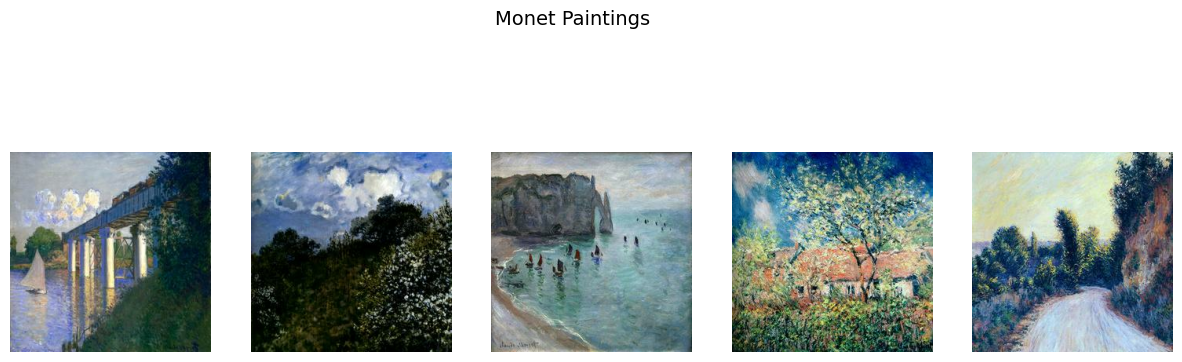

In [3]:
# use Kaggle client library to get path to data
GCS_PATH = KaggleDatasets().get_gcs_path()

# get paths to monet images
monet_paths = tf.io.gfile.glob(GCS_PATH +"/monet_jpg/*.jpg")

# get total number of images
print(f'Total number of Monet images: {len(monet_paths)}')

image = tf.io.read_file(monet_paths[0])  
image = tf.image.decode_jpeg(image, channels=3) 

# Get image dimensions
print(f"Image Dimensions: {image.shape}")

display_random_images(monet_paths, "Monet Paintings", 5)



# EDA: Real Photos

In contrast to our Monet dataset, our real photos dataset is about ~7000 images, or over 20x the size of the Monet dataset.

The image dimensions for our real photos are the exact same as for our Monet images, 256x256x3.

Below, we inspect some of our real photos.  In contrast to the Monet images, the real photos are much more sharp and distinct in nature.

Total number of photos: 7038
Image Dimensions: (256, 256, 3)


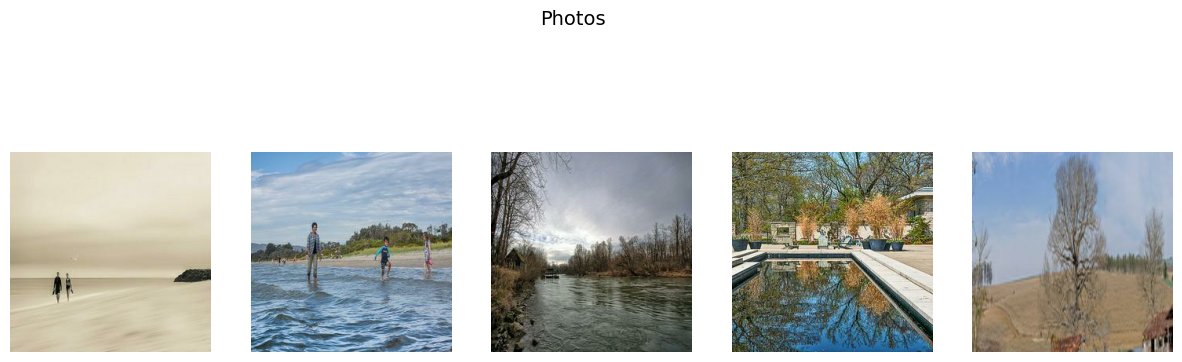

In [4]:
photo_paths = tf.io.gfile.glob(GCS_PATH +"/photo_jpg/*.jpg")

print(f'Total number of photos: {len(photo_paths)}')

photo = tf.io.read_file(photo_paths[0])  
photo = tf.image.decode_jpeg(photo, channels=3) 

print(f"Image Dimensions: {photo.shape}")

display_random_images(photo_paths, "Photos", 5)

# EDA: Dimension Consistency Validation

The Kaggle instructions say that the data **should** all be the same dimension (256x256x3), but it doesn't hurt to validate.  

Below, we run a function that gets all unique dimensions of all images in both the Monet and photo datasets.  

We can confirm that all the images are of the same dimension, which is useful as it means that we require no further processing in order to use these in our GAN.

In [5]:
import tensorflow as tf
import numpy as np

def get_image_shapes(image_paths):
    # use tf dataset as it allows us to process in parallel
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3), num_parallel_calls=tf.data.AUTOTUNE)  
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    shapes = set()
    for batch in dataset:
        shapes.update([tuple(img.shape) for img in batch.numpy()])
    return shapes

# This actually takes quite a while if you run it on the full dataset so for testing purposes it is truncated, but 
# you will get the same results if you run this on the full set.
print("Unique Monet Image Shapes:", get_image_shapes(monet_paths[0:100]))
print("Unique Photo Image Shapes:", get_image_shapes(photo_paths[0:100]))



Unique Monet Image Shapes: {(256, 256, 3)}
Unique Photo Image Shapes: {(256, 256, 3)}


# EDA: Sobel Edge Detection

One of the starkest differences between our Monet images and our real photos is the sharpness of a real photo compared to one of Monet's paintings.  Monet's painting style is intentionally more diffuse and dreamlike.  

As a result, if we apply Sobel filtering, we should be able to see significant differences in the edge map of Monet paintings vs real photos.

Below, we can see that difference illustrated (in grayscale, for easier viewing).  The Monet paintings appear to be "rough" all over and more consistent, with fewer sharp edges and fewer smooth areas.  The real photos, in contrast, are more dichotomous, with sharp edges contrasted against smooth regions.

This is useful to validate because we can use these same edge maps as one measure of performance for our GAN.  If our predicted photos have edge maps more similar to the Monet paintings, then the model has performed as expected in at least one metric.

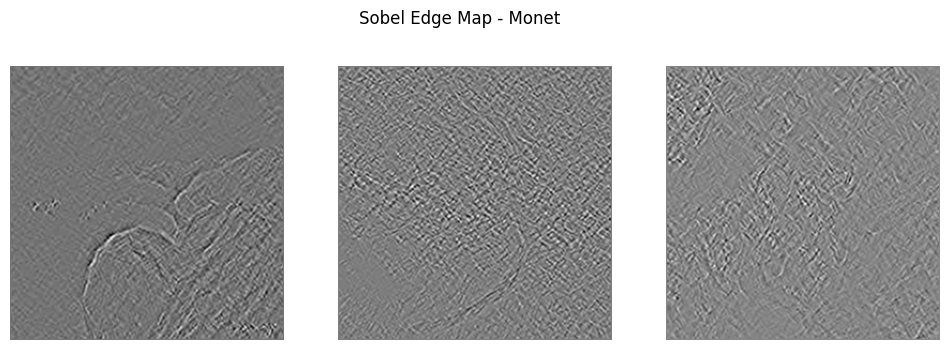

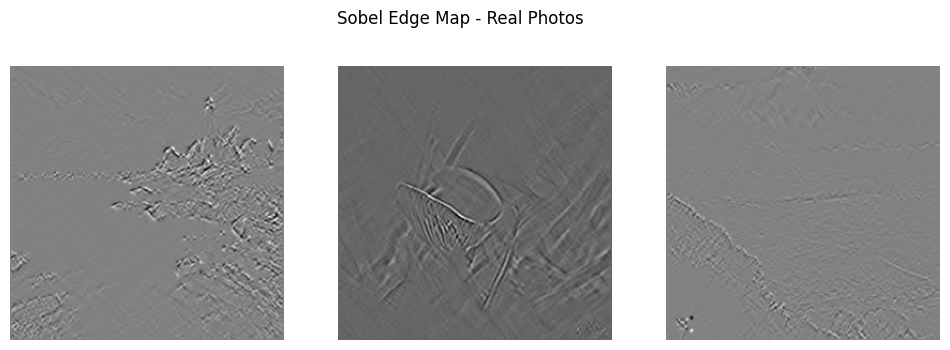

In [6]:
import cv2

def plot_edge_maps(image_paths, title):
    plt.figure(figsize=(12, 4))
    for i, image_path in enumerate(image_paths):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3).numpy()
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Sobel(image_gray, cv2.CV_64F, 1, 1, ksize=5)  

        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(edges, cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_edge_maps(monet_paths[10:13], "Sobel Edge Map - Monet")
plot_edge_maps(photo_paths[4:7], "Sobel Edge Map - Real Photos")


# Get All TFREC Filenames

Our TFREC files contain all of our image data and metadata.  We use them later to easily create TF datasets.


In [7]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# Define Image Processing Functions

Here, we define two functions that we will use when building our TF datasets.

The first, *decode_image*, decodes the JPG image into a tensor and normalizes its values.  It also ensures that the image is in the correct dimension for our model (256x256).

The second *read_tfrecord*, extracts the image data from a TFRecord entry.

In [8]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


# Build TF Datasets

Here, we build our TF datasets for both our real photos and our Monet paintings.  

TF Datasets are extremely efficient at loading and processing large datasets and allow for parallel operations.

In [9]:
def build_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames).map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset.batch(1)

monet_ds = build_dataset(MONET_FILENAMES)
photo_ds = build_dataset(PHOTO_FILENAMES)

# Build Our Generator

Our generator will be transforming our real photos into the style of Monet.

It has the following architecture:
- Initial convolution (extracts initial, basic features from the image)
- Downsampling (remove details in order for model to learn broader/more general patterns)
- Residual blocks (apply the actual transformations to the image.  skip connections are used to add to the image without losing too much of the original image)
- Upsampling (upsample the image back to the expected dimensions)
- Final output layer (undergoes a final convolution and returns the image in the expected dimensions, normalized)



In [10]:
def residual_block(x):
    filters = x.shape[-1]
    # residual block with two convolutional layers
    res = Conv2D(filters, (3,3), padding="same")(x)
    res = BatchNormalization()(res)
    res = Activation("relu")(res)
    res = Conv2D(filters, (3,3), padding="same")(res)
    res = BatchNormalization()(res)
    # use skip connections to retain some of the original image information
    return tf.keras.layers.Add()([x, res])  

def Generator():
    inputs = Input(shape=[256,256,3])
    
    # initial convolution
    x = Conv2D(64, (7, 7), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    
    # downsampling
    x = Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # residual blocks.  for 256x256 images, 9 residual blocks is supposed to be optimal according to the CycleGAN paper
    # (see references)
    for _ in range(9):  
        x = residual_block(x)

    # upsampling
    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # output layer
    outputs = Conv2D(3, (7, 7), padding="same", activation="tanh")(x)

    return keras.Model(inputs, outputs)

# Build Our Discriminator

Our discriminator will be classifying our generated images as real or fake.

For this discriminator, we used a PatchGAN as this was the discriminator used in the original CycleGAN paper (see references).  PatchGAN is effective as it classifies small patches of an image rather than the entire image at once.  In a sense, it is more detailed, as it might give one part of an image a failing grade and the other part a passing grade, which is more granular feedback that forces our discriminator to perform better. 

The discriminator is architected as follows:
- Input layer
- Convolutional layers
- Output layer

Each convolutional layer downsamples the image further, until we output a 32x32 grid of probabilities where each probability represents a patch of the image and its ultimate classification (real vs fake).

In [11]:
def Discriminator():
    # input layer
    inputs = Input(shape=[256, 256, 3], name='input_image')

    # convolutional layers which downsample the image
    x = Conv2D(64, (4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # output layer 
    outputs = Conv2D(1, (4, 4), strides=1, padding="same", activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

# Build the CycleGAN model

This CycleGAN implementation is the same as in the tutorial notebook (see references).

CycleGAN is an unsupervised translation model that allows us to translate an image between two domains (in this case, between the domain of real photos and the domain of Monet paintings) without requiring that the images be paired.

The Generator and Discriminator classes that we defined previously are basically used/managed by this class/model.

For each photo and Monet image combination, the model performs the following:
- Converts photo to Monet style and then back to a photo, then does the same process but for a Monet image. The photo when converted to the opposite class is "faked", and the photo when converted back to its own class is "cycled"
- Converts an image directly to the image's own style (e.g. Monet => Monet), again, for both classes
- Runs the discriminator on the original (real) images of both classes
- Runs the discriminator on the faked images of both classes
- Evaluates loss on generated images
- Evaluates loss on the "cycled" images (the ones that were converted back and forth)
- Evalutes total generator loss (all previous loss + "identity" loss i.e. the loss when transforming an image to its own class)
- Evaluates discriminator loss
- Update gradients and apply updated gradients to optimizers


In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define Loss Functions

Our loss functions are critical to our model as they determine how well the model can evaluate the generator's performance and guide its improvements.

Below, we define four loss functions which calculate discriminator loss, generator loss, cycle loss and identity loss.

- Discriminator loss: calculates loss when discriminating on real images (1) and generated images (0).  We half the sum of these losses as, if we don't, the gradient updates might be too large and therefore disruptive.  This loss represents the failure of the discriminator to discriminate correctly between real and fake.
  
- Generator loss: calculates the loss when generating fake Monet images.  Because the generator is trying to fool the discriminator, the loss is calculated against values of 1 (unlike with the discriminator's loss function).  This represents the failure of the generator to fool the discriminator.

  
- Cycle loss: calculates the loss of an image that has been converted to the opposing class and back, compared to the original image.  Ideally, the original and "cycled" image would be identical, so we take the mean of the absolute value of the differences between the real and cycled image.

  
- Identity loss: calculates the loss of an image that has been converted to its own class.  This is basically the same comparison as the cycle loss function except the loss is halved since only one conversion was performed (compared to with cycle loss, where two conversions were performed).

In [13]:
with strategy.scope():

    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    
    def discriminator_loss(real, generated):
        real_loss = loss_function(tf.ones_like(real), real)
        generated_loss = loss_function(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return loss_function(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Model Comparison

There are a few reasons that we chose this overall model architecture over other, comparable options.

For our Generator, we chose an architecture that utilizes residual blocks and skip connections in order to try and retain valuable structure from the original images, since this is a "style to style" task.  A simpler architecture would have likely yielded poorer transformations with loss of important visual information, and skip connections in our model help prevent any issues with vanishing gradients.

For our Discriminator, we distinctly chose a PatchGAN approach as we believed that this would be more appropriate for the task at hand and would better classify our Monet transformations than a discriminator which considers the full image context.  PatchGAN is explicitly stated in the CycleGAN paper as the used discriminator.

For CycleGan, we chose this model frankly a) because it was referenced in the tutorial notebook but b) also because CycleGAN is an appropriate choice when performing unpaired style to style tasks.  One competing model, Pix2Pix, might be a good choice except that it requires paired images, which we do not have the luxury of having.



# Define Function to Train CycleGAN Model

Since we will be doing some hyperparameter tuning, we want to define a function to easily encapsulate the model training logic.

Our model training function initializes optimizers for our generators and discriminators.  

It then initializes our CycleGAN class with two Generators and two Discriminators.  

We then compile the model, passing in our loss functions and optimizers, and finally we fit the model with our data.

In [14]:
with strategy.scope():

    def train_model(gen_lr, disc_lr):
    
        monet_generator_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.5)
        photo_generator_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.5)
        
        monet_discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr, beta_1=0.5)
        photo_discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr, beta_1=0.5)
        
        cycle_gan_model = CycleGan(
            Generator(), Generator(), Discriminator(), Discriminator()
        )
    
        # this is needed when using a TPU
        cycle_gan_model.build((256,256,3))
        
        cycle_gan_model.compile(
            m_gen_optimizer = monet_generator_optimizer,
            p_gen_optimizer = photo_generator_optimizer,
            m_disc_optimizer = monet_discriminator_optimizer,
            p_disc_optimizer = photo_discriminator_optimizer,
            gen_loss_fn = generator_loss,
            disc_loss_fn = discriminator_loss,
            cycle_loss_fn = calc_cycle_loss,
            identity_loss_fn = identity_loss
        )
        cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=20)

        return cycle_gan_model


# Initial Pre-Tuning Model

Here, we fit the model with the original learning rates from the tutorial notebook, which are the same for both generator and discriminator.

In [15]:
with strategy.scope():
    cycle_gan_model = train_model(2e-4, 2e-4)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 ━━━━━━━━━━━━━━━━━━━━ 248s 440ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 9.4846 - photo_disc_loss: 0.5970 - photo_gen_loss: 9.6736
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.5384 - monet_gen_loss: 9.1701 - photo_disc_loss: 0.5147 - photo_gen_loss: 9.3384
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.5058 - monet_gen_loss: 8.8816 - photo_disc_loss: 0.5156 - photo_gen_loss: 8.9361
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 453ms/step - monet_disc_loss: 0.4415 - monet_gen_loss: 9.2164 - photo_disc_loss: 0.4278 - photo_gen_loss: 9.4159
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.4183 - monet_gen_loss: 9.0655 - photo_disc_loss: 0.4871 - photo_gen_loss: 8.8558
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.4073 - monet_gen_loss: 8.9384 - photo_disc_loss: 0.4631 - photo_gen_loss: 8.8102
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.4124 - monet_gen_loss: 8.5513 - photo_disc_loss: 0.4860 - photo_gen_loss: 8.3465
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet

# Define Image Result Rendering Function

Part of assessing the performance of our models is evaluating the visual output.  Here, we define a function to render some images generated by our model.

In [16]:
def evaluate_images(generator):
    _, ax = plt.subplots(3, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.take(3)):
        prediction = generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input")
        ax[i, 1].set_title("Output")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

# Evaluate Images from Pre-Tuning Model

Render and visually inspect some images from our first model.  As we can see, our generated images have clearly been transformed from their original versions.

However, there appear to be some notable black splotches in the images, which are decidedly un-Monet.  

We speculate that this could possibly be a form of mode collapse caused by a generator which is too strong i.e. has too high of a learning rate.  We will try tuning the learning rate next, by decreasing the generator learning rate and increasing the discriminator learning rate to see if this problem is resolved.

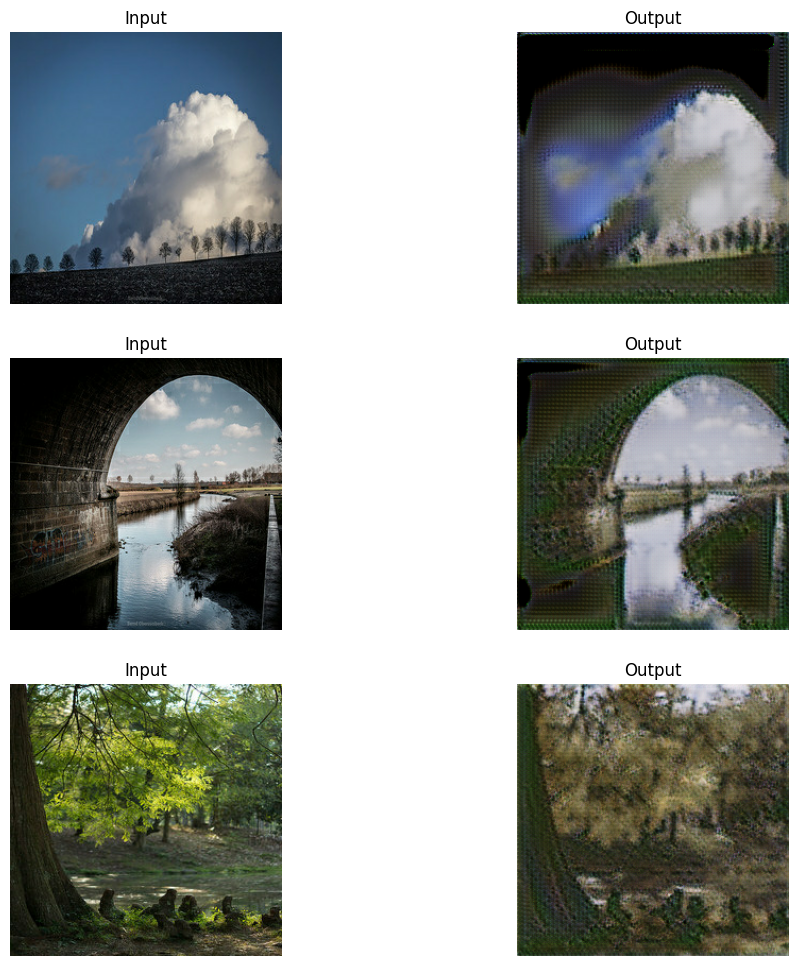

In [17]:
evaluate_images(cycle_gan_model.m_gen)

# Evaluate Edge Map from Generated Images 

Evaluate the edges of our generated images.  While not perfect, we can see that there is more noise and less smoothness in our generated images, implying that they have become more similar (at least on an edge level) to the Monet images.

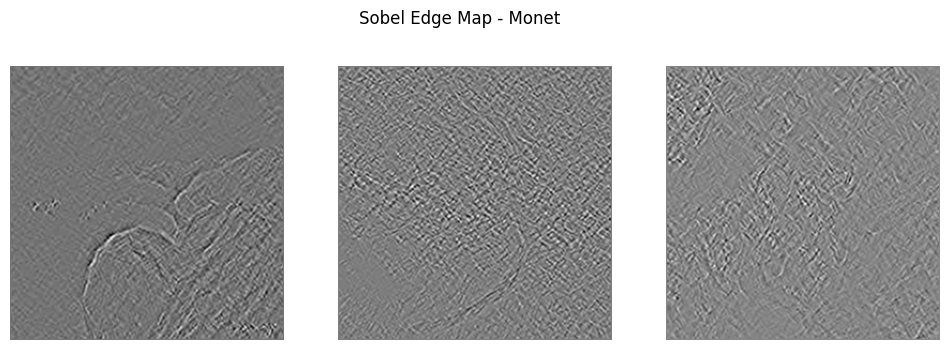

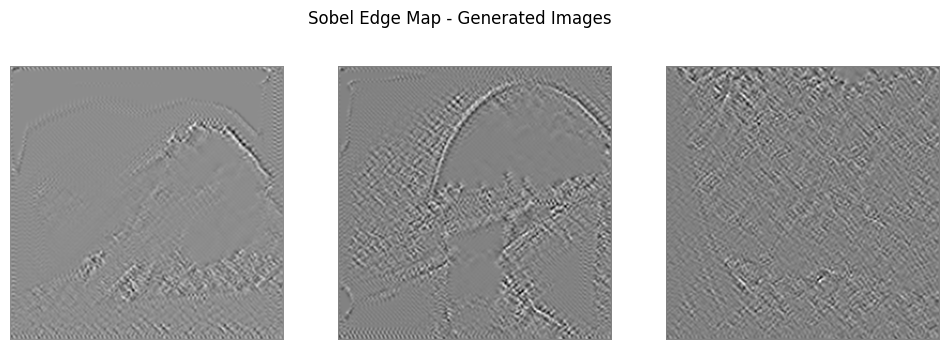

In [18]:
photo_sample = list(photo_ds.take(3).as_numpy_iterator())

# plot the real monet images 
plot_edge_maps(monet_paths[10:13], "Sobel Edge Map - Monet")

plt.figure(figsize=(12, 4))

# plot the generated monet images
for i, img in enumerate(photo_sample):
    prediction = cycle_gan_model.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image_gray = cv2.cvtColor(prediction, cv2.COLOR_RGB2GRAY)  
    edges = cv2.Sobel(image_gray, cv2.CV_64F, 1, 1, ksize=5) 

    plt.subplot(1, len(photo_sample), i + 1)
    plt.imshow(edges, cmap="gray")
    plt.axis("off")
    
plt.suptitle('Sobel Edge Map - Generated Images')
plt.show()


# Hyperparameter Tuning pt. 1

We first tune our hyperparameters by decreasing our generator learning rate and increasing our discriminator learning rate.  Hopefully, this will fix the previous issue we had with black splotches in our output images.

It's important for learning rates to be appropriately set for our generator and discriminator.  If there is an imbalance in learning rates between generator and discriminator, and one network learns too fast, the other network may fail to learn as a result.  

In [19]:
with strategy.scope():
    model_tune_1 = train_model(1e-4, 3e-4)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 247s 455ms/step - monet_disc_loss: 0.5718 - monet_gen_loss: 9.7692 - photo_disc_loss: 0.6138 - photo_gen_loss: 9.7501
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.2751 - monet_gen_loss: 10.1101 - photo_disc_loss: 0.5390 - photo_gen_loss: 8.9919
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 455ms/step - monet_disc_loss: 0.3419 - monet_gen_loss: 9.5632 - photo_disc_loss: 0.4810 - photo_gen_loss: 8.8490
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 455ms/step - monet_disc_loss: 0.3479 - monet_gen_loss: 9.1419 - photo_disc_loss: 0.4322 - photo_gen_loss: 8.6577
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.3823 - monet_gen_loss: 9.0426 - photo_disc_loss: 0.4012 - photo_gen_loss: 8.7179
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 455ms/step - monet_disc_loss: 0.3050 - monet_gen_loss: 9.4263 - photo_disc_loss: 0.3723 - photo_gen_loss: 9.0411
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/

# Evaluate Images from Tuned Model #1

Render and visually inspect some images from our first tuned model.  

As we can see, the black splotches issue is gone, and the images appear to be a bit more Monet-looking, though they are still far from perfect imitations.

Next, we will try the opposite of what we did previously - we will actually increase the generator learning rate from the default, and decrease the discriminator learning rate, simply to see if the results are as we expect (more black splotches?).

Due to notebook runtime constraints, our next tuning will be our final parameter tuning.

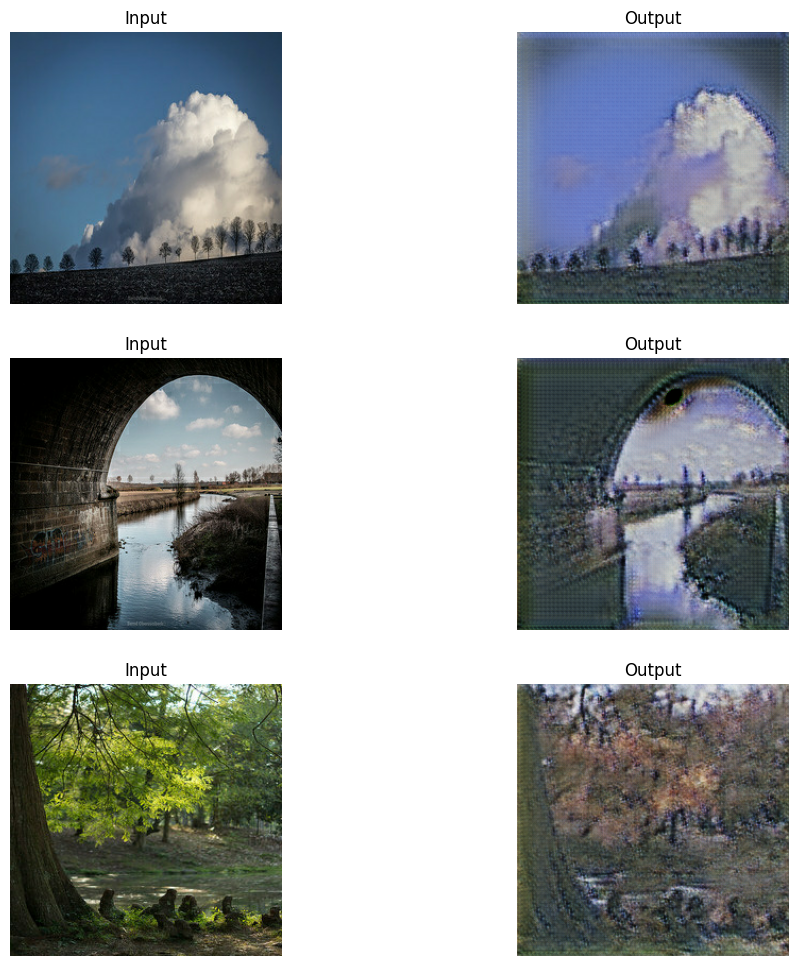

In [20]:
evaluate_images(model_tune_1.m_gen)

# Hyperparameter Tuning pt. 2

We again tune our hyperparameters by increasing our generator learning rate and decreasing our discriminator learning rate (from the defaults for both).  This is essentially the opposite of what we did previously.

In [21]:
with strategy.scope():
    model_tune_2 = train_model(3e-4, 1e-4)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 244s 455ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 9.6293 - photo_disc_loss: 0.6003 - photo_gen_loss: 9.8759
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.5622 - monet_gen_loss: 8.8867 - photo_disc_loss: 0.5249 - photo_gen_loss: 9.1911
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 455ms/step - monet_disc_loss: 0.5119 - monet_gen_loss: 9.0164 - photo_disc_loss: 0.5378 - photo_gen_loss: 8.9720
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 138s 455ms/step - monet_disc_loss: 0.4801 - monet_gen_loss: 8.7180 - photo_disc_loss: 0.5423 - photo_gen_loss: 8.5643
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.4523 - monet_gen_loss: 8.2537 - photo_disc_loss: 0.5093 - photo_gen_loss: 8.0511
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - monet_disc_loss: 0.4488 - monet_gen_loss: 7.9420 - photo_disc_loss: 0.5177 - photo_gen_loss: 7.7488
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 138s 454ms/s

# Evaluate Images from Tuned Model #2

Render and visually inspect some images from our second tuned model.

Interestingly, the black splotches still appear, but are less noticeable than with our original model. 

The images also have a noticeable yellowish/sepia tint to them.  The generator must have learned this as a "shortcut" to fool the discriminator, and applied it too liberally.

In hindsight, our second model probably performed the best.

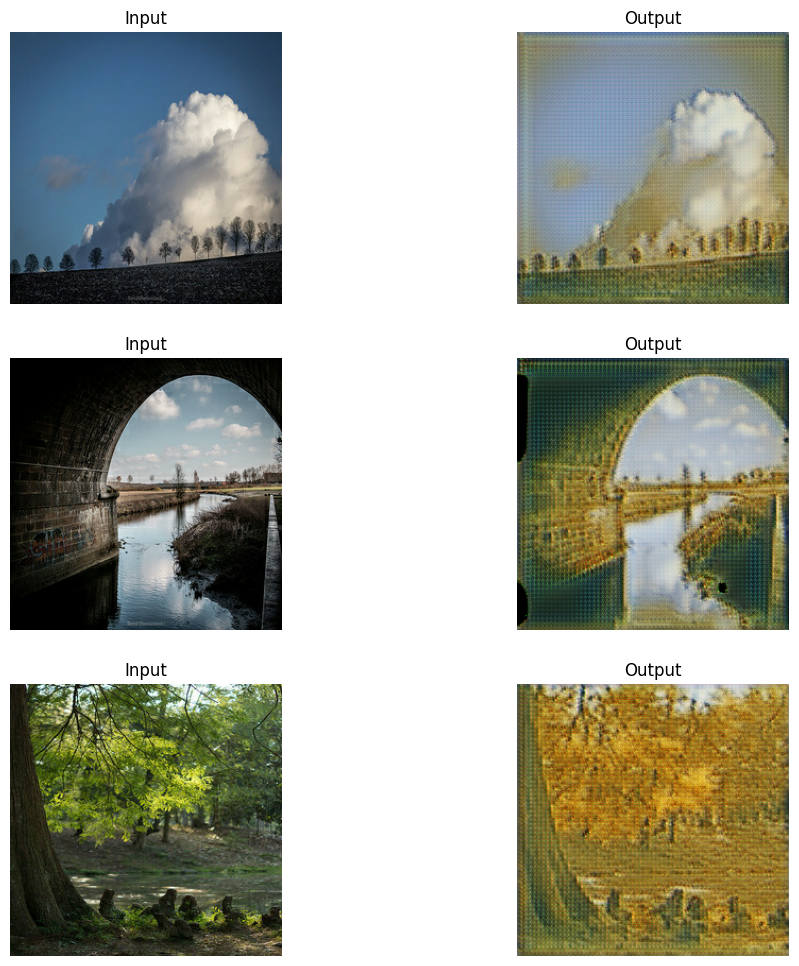

In [22]:
evaluate_images(model_tune_2.m_gen)

# Results and Conclusion

Out of the three models we tested, arguably the best results came from our second model, which had a generator learning rate that was decreased from our original rate, and a discriminator learning rate which was increased from our original rate.

With both our first and third models, which had comparably higher generator learning rates, we experienced issues with what appears to be some kind of mode collapse where black splotches appeared on our output images.

These conclusions would lead me to believe that our likely best course of action for further tuning hyperparameters would be to further decrease the generator learning rate in comparison to the discriminator learning rate, and to experiment more with both increased and decreased discriminator learning rates.

For the Kaggle competition, we ultimately received an MIFID score of ~98, which is not great but which placed us firmly in the middle of the current leaderboard.

See below for our tuning table summary.

In [10]:
import pandas as pd
data = {
    "Model": ["Model 1", "Model 2", "Model 3"],
    "Generator LR": [0.0002, 0.0001, 0.0003],
    "Discriminator LR": [0.0002, 0.0003, 0.0001]
}

results_df = pd.DataFrame(data)
print('Hyperparameter Tuning Summary Table:')
results_df.head()


Hyperparameter Tuning Summary Table:


Model  Generator LR  Discriminator LR
0  Model 1        0.0002            0.0002
1  Model 2        0.0001            0.0003
2  Model 3        0.0003            0.0001

# Create submission zip

Create the submission zip for the Kaggle competition.


In [23]:
import PIL
! mkdir ../images
i = 1
for img in photo_ds:
    prediction = cycle_gan_model.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Github link

https://github.com/unit4216/gan-monet

# References

**Amy Jang's Monet CycleGAN tutorial:**
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Introduction-and-Setup

**CycleGAN paper:**
https://arxiv.org/pdf/1703.10593